In [7]:
library(tidyverse)
library(tidymodels)

# **DSCI 100 Project: Predicting Usage of a Video Game Research Server**

# Introduction:
When we received data from the Plaicraft.ai team, they left us with several questions they were most interested in answering. Out of all of their questions, we were most drawn to question 1: "which "kinds" of players are most likely to contribute a large amount of data"?

## Specifically, we want to answer the following question: 
**Can age, gender, past experience level, and typical time of day played accurately predict whether someone will play more or less than the typical plaicraft.ai player?**
- Specifically, will those explanatory variables predict whether someone's total played hours will be in the 0-25th percentile, 25-50th percentile, 50-75th percentile, or 75-100th percentile of the players represented in the training data?

This notebook documents our process to answering this question, as well as our final findings.

## Still TODO parts of the introduction
provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
clearly state the question you tried to answer with your project
identify and fully describe the dataset that was used to answer the question

**//TODO #1:** Finish This by adding more background information on the topic.

# Methods & Results:

## Description of what the rubric says that this section should be
describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
loads data 
wrangles and cleans the data to the format necessary for the planned analysis
performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
performs the data analysis
creates a visualization of the analysis 
note: all figures should have a figure number and a legend

**//TODO #2:** Before we do our testing-training split, we need to add "typical time of day played" to the players_data data frame.
How to do this: 
1. First, describe what time ranges you will define as "Morning", "Midday", "Afternoon", "Night", and "Past Midnight".
2. Then, mutate sessions_data such that you have a column called "start_time_of_day" for each session, which should contain the time range played based on the "start_time"
3. Also, mutate sessions_data such that you have a column called length_of_session for every session (which is calculated by subtracting the end_time from the start_time)
4. Next, (i think you use the group by and summarize functions for this part), use the mode function (i think) to make it such that the sessions data frame contains only one entry per hashed email, and this one entry has 2 variables: hashed email and typical_time_of_day_played
- Note: to avoid conflicts for people who had for example, three sessions in the morning and three sessions at night, typical_time_of_day_played should be based on which start_time_of_day value had the largest total length_of_session. (i.e. if a hashed email has 2 sessions during Night of 1 hour and 2 hours, and 3 sessions during the day of 30 minutes each, because 3 hours > 1.5 hours, "Night" should be the typical_time_of_day_played
5. Finally, bind_cols with the players_data dataset, so that now each entry in players_data has an extra column called typical_time_of_day_played

### **Data Extraction & Wrangling:**

In [8]:
set.seed(872) #setting the seed because we're doing a testing-training split

url1 <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
url2 <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
players_data <- read_csv(url1)
sessions_data <- read_csv(url2)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### players_data

In [9]:
head(players_data)
# individualId & organizationName are all NA thus we drop the columns

experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


In [10]:
# get rid of the two entire columns that have NA as every data point & name (redundant information to hashedEmail)
players_data <- players_data |>
    select(-individualId, -organizationName, -gender, -name)
    
# remove data points that have gender listed as "Prefer not to say" because we can't use "Prefer not to say" as a predictor
# alan's note: we prob want to keep these data points since data size is small, can just exclude gender feature to avoid gender bias in our model
# players_data <- players_data |> filter(gender != "Prefer not to say")
head(players_data)

experience,subscribe,hashedEmail,played_hours,age
<chr>,<lgl>,<chr>,<dbl>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,17


In [11]:
players_data <- players_data |>
    mutate(over_5_hrs = case_when(played_hours > 5 ~ TRUE,
                                  TRUE ~ FALSE))
head(players_data)

experience,subscribe,hashedEmail,played_hours,age,over_5_hrs
<chr>,<lgl>,<chr>,<dbl>,<dbl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,9,TRUE
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,17,FALSE
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,17,FALSE
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,21,FALSE
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,21,FALSE
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,17,FALSE


#### sessions_data

In [12]:
head(sessions_data)

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [13]:
# added minutes of each session
sessions_data_minutes <- sessions_data |>
    mutate(start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M")) |>
    mutate(end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M")) |>
    mutate(session_min = difftime(end_time, start_time)) |>
    mutate(session_min = as.double(session_min, units = "mins")) |>
    select(hashedEmail, start_time, session_min)

# added time of day of each session start time
past_midnight_hours = c(1, 2, 3, 4, 5, 6)
morning_hours = c(7, 8, 9, 10, 11, 12)
afternoon_hours = c(13, 14, 15, 16, 17, 18)
night_hours = c(19, 20, 21, 22, 23, 24)

sessions_data_minutes_tod <- sessions_data_minutes |> 
    mutate(start_hour = strftime(start_time, format="%H")) |>
    mutate(start_hour = as.double(start_hour)) |>
    mutate(start_time_of_day = case_when(start_hour %in% past_midnight_hours ~ "Past Midnight",
                                         start_hour %in% morning_hours ~ "Morning",
                                         start_hour %in% afternoon_hours ~ "Afternoon",
                                         TRUE ~ "Night")) |>
    select(hashedEmail, session_min, start_time_of_day)


#create function for getmode(most frequent chr occurance)
getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

# For each hashEmail: get most frequent start time of day & average session length (min)
sessions_data_avg <- sessions_data_minutes_tod |>
    group_by(hashedEmail) |>
    summarize(most_frequent_start_time = getmode(start_time_of_day))
              # avg_session_length = mean(session_min, na.rm=TRUE))
    
head(sessions_data_avg)

hashedEmail,most_frequent_start_time
<chr>,<chr>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Night
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Past Midnight
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,Night
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,Past Midnight
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,Afternoon
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,Morning


In [14]:
joined_players_data <- players_data |>
    inner_join(sessions_data_avg, by = "hashedEmail") |>
    relocate(hashedEmail) |>
    relocate(over_5_hrs, .after = most_frequent_start_time)
head(joined_players_data)

hashedEmail,experience,subscribe,played_hours,age,most_frequent_start_time,over_5_hrs
<chr>,<chr>,<lgl>,<dbl>,<dbl>,<chr>,<lgl>
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,Pro,TRUE,30.3,9,Night,TRUE
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,Veteran,TRUE,3.8,17,Past Midnight,FALSE
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,Veteran,FALSE,0.0,17,Past Midnight,FALSE
23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,Amateur,TRUE,0.7,21,Past Midnight,FALSE
7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,Regular,TRUE,0.1,21,Past Midnight,FALSE
1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,Amateur,FALSE,0.0,21,Morning,FALSE


In [15]:
# No missing values in our wrangled data set
which(is.na(joined_players_data))

integer(0)

In [16]:
# do a testing-training split so we can do our exploratory data analysis on only our training data
joined_players_data_split <- initial_split(joined_players_data, prop = 0.8, strata = over_5_hrs)
training_data <- training(joined_players_data_split)
testing_data <- testing(joined_players_data_split)

## **Exploratory Data Analysis:**

When we intially received the question, we had brainstormed the idea of predicting total amount of playtime based on our explanatory variables. This would have involved making a regression model. However, when we plotted the total play time of all of the players, this is the graph we got:

List of 1
 $ text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 20
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

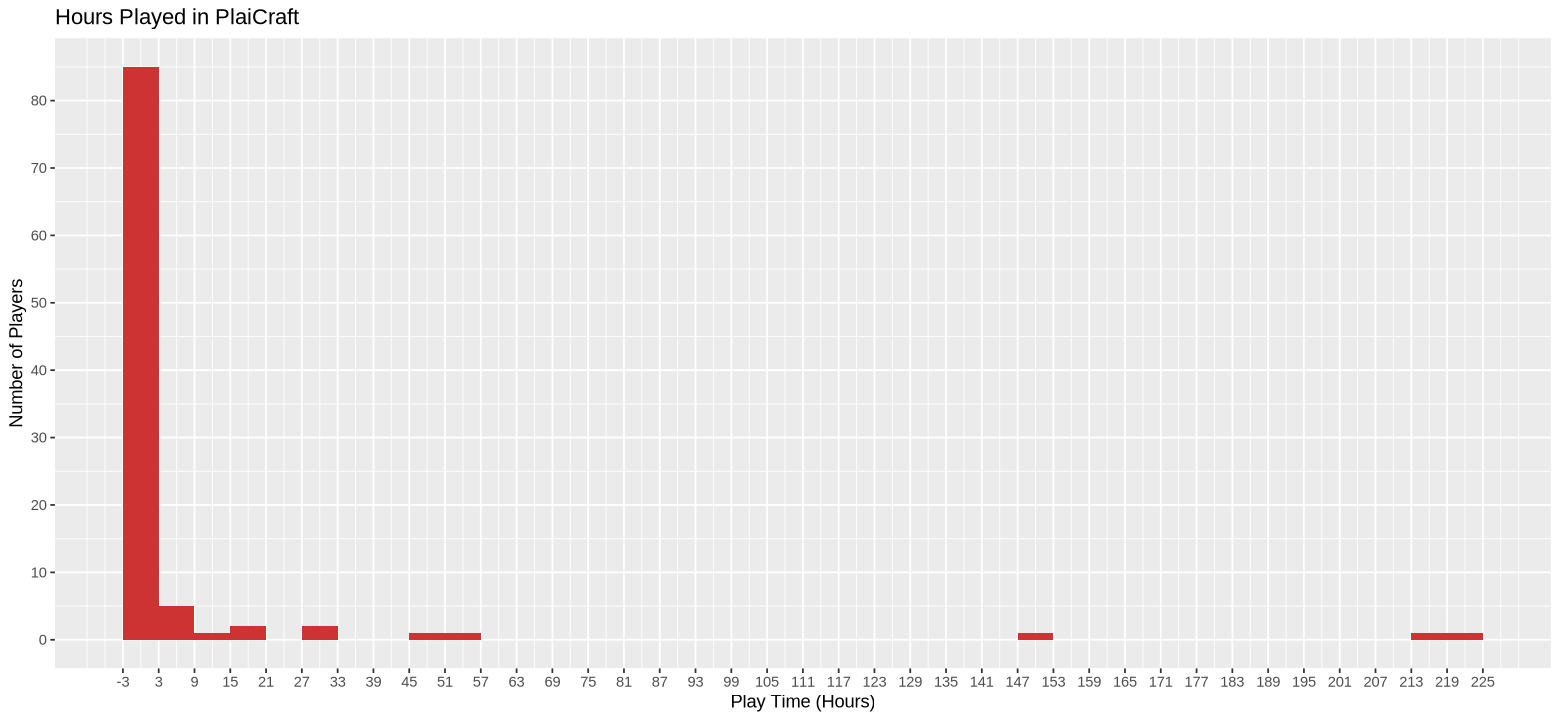

In [17]:
options(repr.plot.width = 13, repr.plot.height = 6) 
played_hours_plot <- ggplot(training_data, aes(x = played_hours)) +
                        geom_histogram(binwidth = 6, fill = "brown3") +
                        labs(x = "Play Time (Hours)",
                             y = "Number of Players",
                             fill = "experience",
                             title = "Hours Played in PlaiCraft") + 
                        scale_x_continuous(breaks=seq(-3,226,6)) +
                        scale_y_continuous(breaks=seq(0,170,10))
                        theme(text = element_text(size = 20))
played_hours_plot

**//TODO #3: Edit this after we do our testing-training data split**
If we look at the distribution of play times of each player, we can see that 4 total players would majorly skew any regression model, because these 4 players all had more than 30 times the median number of played hours per player.

This fact made us reconsider our approach to answering our question: if it's really only important to predict what kinds of players contribute large amounts of data to the project, why would we let a single player who played around 220 hours skew the entire model? When recruiting a lot of people, it's far more important to recruit a lot of people who have a high chance of giving a good amount of data, rather than focusing our efforts on recruiting one person who fits the same demographics as "the one person who happened to contribute 220 hours of data".

**//TODO #4:** Make multiple visualizations based on the distribution of training_data's variables that we can later analyze
1. Calculate the 25th, 50th, and 75th percentile of all observations of played_hours in training_data
2. Mutate training_data so that each row also includes a categorical variable called percentile_level ("0-25", "25-50", "50-75", or "75-100") based on played_hours for the player
3. Make visualizations using percentile_level, age, gender, experience, and typical_time_of_day_played
- **IMPORTANT:** Be aware that until your groupmate completes TODO #2, typical_time_of_day_played will always be "Night" and although testing_data exists, it contains the entire players_data data set. We still need visualizations for all of these variables though, even typical_time_of_day_played. It will work after TODO #2 is completed

In [18]:
percentiles <- quantile(training_data$played_hours, probs = c(0.25, 0.50, 0.75), na.rm = TRUE)

print(percentiles)

  25%   50%   75% 
0.100 0.450 1.625 


In [20]:
training_data <- training_data |>
    mutate(
        percentile_level = case_when(
            played_hours <= percentiles[1] ~ "0-25",
            played_hours > percentiles[1] & played_hours <= percentiles[2] ~ "25-50",
            played_hours > percentiles[2] & played_hours <= percentiles[3] ~ "50-75",
            played_hours > percentiles[3] ~ "75-100"
        )
    )

head(training_data)

hashedEmail,experience,subscribe,played_hours,age,most_frequent_start_time,over_5_hrs,percentile_level
<chr>,<chr>,<lgl>,<dbl>,<dbl>,<chr>,<lgl>,<chr>
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,Veteran,TRUE,3.8,17,Past Midnight,FALSE,75-100
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,Veteran,FALSE,0.0,17,Past Midnight,FALSE,0-25
23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,Amateur,TRUE,0.7,21,Past Midnight,FALSE,50-75
7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,Regular,TRUE,0.1,21,Past Midnight,FALSE,0-25
1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,Amateur,FALSE,0.0,21,Morning,FALSE,0-25
8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,Amateur,TRUE,0.1,17,Past Midnight,FALSE,0-25


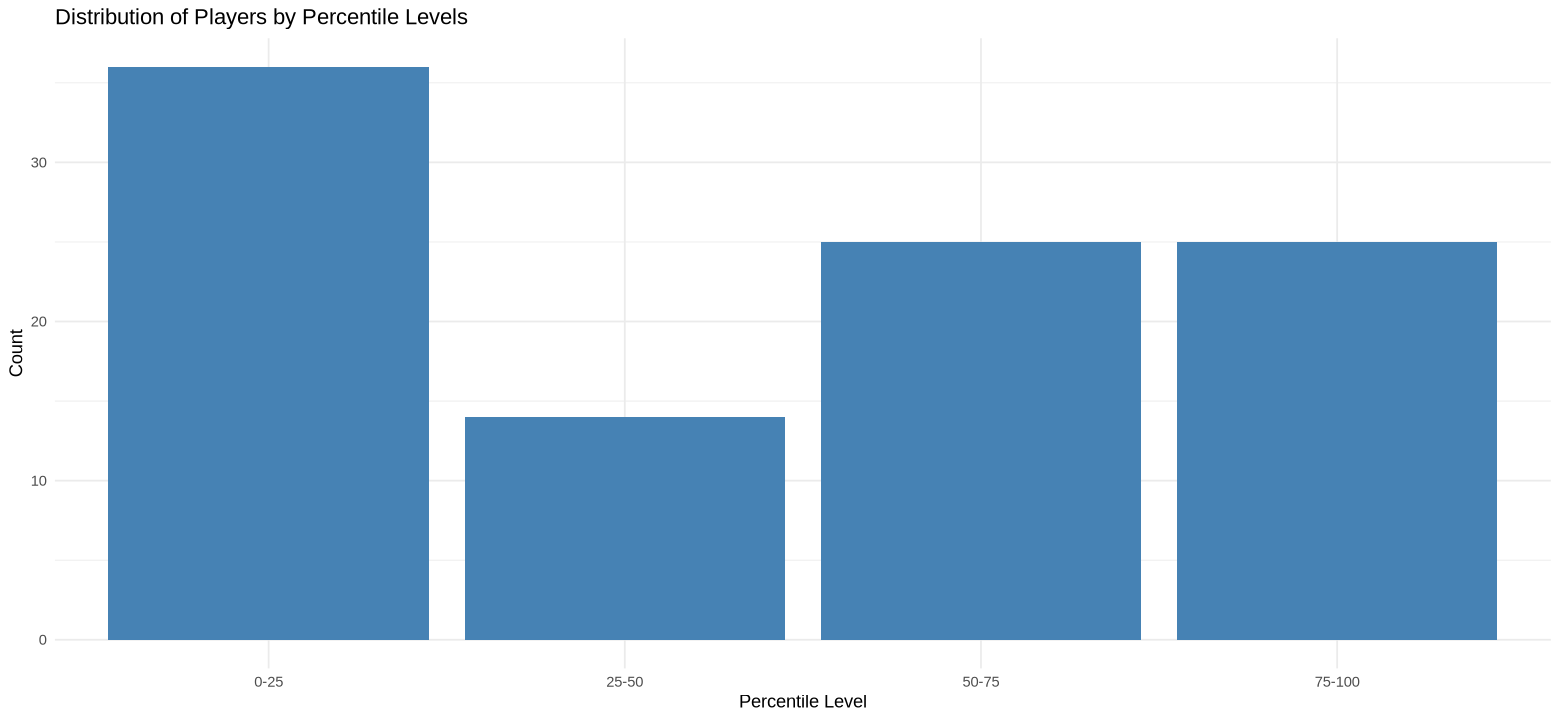

In [21]:
ggplot(training_data, aes(x = percentile_level)) +
    geom_bar(fill = "steelblue") +
    labs(
        title = "Distribution of Players by Percentile Levels",
        x = "Percentile Level",
        y = "Count"
    ) +
    theme_minimal()

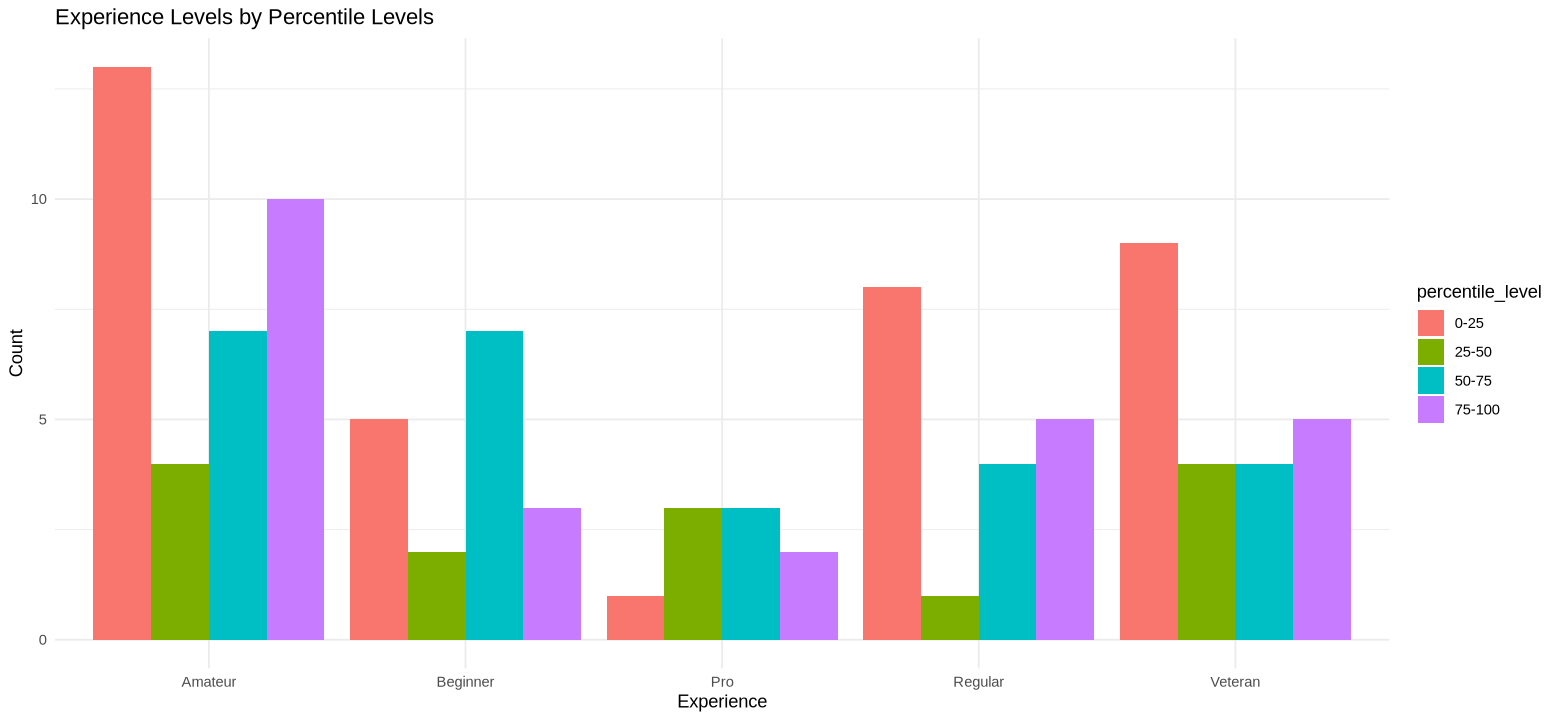

In [27]:
ggplot(training_data, aes(x = experience, fill = percentile_level)) +
    geom_bar(position = "dodge") +
    labs(
        title = "Experience Levels by Percentile Levels",
        x = "Experience",
        y = "Count"
    ) +
    theme_minimal()

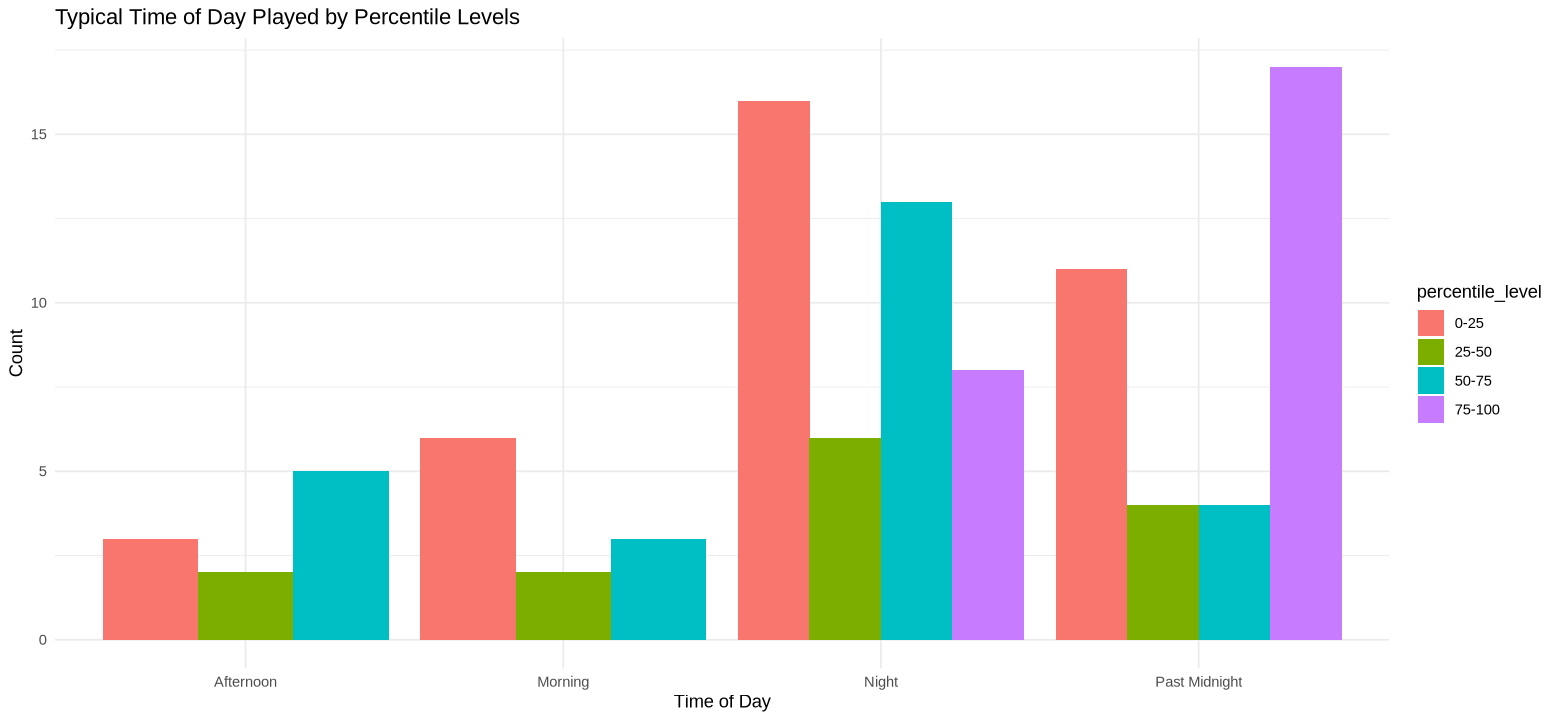

In [25]:
ggplot(training_data, aes(x = most_frequent_start_time, fill = percentile_level)) +
    geom_bar(position = "dodge") +
    labs(
        title = "Typical Time of Day Played by Percentile Levels",
        x = "Time of Day",
        y = "Count"
    ) +
    theme_minimal()

**//TODO #5:** Make the code for a knn classification algorithm that will take in the explanatory variables age, gender (make sure that we split gender into "female", "male", and "other"), typical_time_of_day_played, and experience to predict whether someone will be in the 0-25th, 25-50th, 50-75th, or 75-100th percentile of players
1. Calculate the 25th, 50th, and 75th percentile of all observations of played_hours in training_data
2. Mutate training_data so that each row also includes a categorical variable called percentile_level ("0-25", "25-50", "50-75", or "75-100") based on played_hours for the player
3. Create a classification algorithm for calculating percentile_level based on age, gender, typical_time_of_day_played and experience. Do all the things you need to do to make sure that you make a good classification model. (reread the textbook for this)
- **IMPORTANT:** Be aware that until your groupmate completes TODO #2, typical_time_of_day_played will always be "Night" and although testing_data and training_data exist, they are currently the same thing. Make your code in a way such that it will work when testing_data and training_data are actually turned into the correct data frames.
4. Run the classification algorithm on the testing data (read the above "IMPORTANT" note before this)

# Discussion:

# Still TODO Parts of this section
//TODO
summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?